### Analysis of Zcash block times

### Import libraries

In [1]:
import pathlib
from copy import deepcopy

import matplotlib.pyplot as plt
from isthmuslib import machine_time, VectorSequence as Blockchain  # VERSION 0.0.82 syntax

### Data wrangling

In [2]:
data_path: pathlib.Path = pathlib.Path.cwd() / 'data' / 'local_only' / 'zcash_height_timestamp.csv'

Check that the file exists

In [3]:
if not data_path.exists():
    raise FileNotFoundError(f"Cannot find file: {data_path}")

Load the file

In [4]:
blockchain: Blockchain = Blockchain().read_csv(data_path, inplace=False, basis_col_name='block_number',
                                               color=[x / 255 for x in (244, 183, 40)])

Drop extra rows for blocks with multiple transactions

In [5]:
blockchain.data = blockchain.data.groupby(by='block_number').first()
blockchain.data.drop([0, 1], inplace=True)  # Drop the genesis block and one following
blockchain.data.reset_index(inplace=True, drop=False)

Convert times to timestamps. _(todo - use pandas builtin instead)_

In [6]:
blockchain.data['block_timestamp_int'] = machine_time(blockchain.data.loc[:, 'block_timestamp'].tolist(),
                                                      disable_progress_bar=False)

  0%|          | 0/1669073 [00:00<?, ?it/s]

Calculate the diffs

In [7]:
blockchain.data['discovery_time_sec'] = blockchain.data.loc[:, 'block_timestamp_int'].diff()
blockchain.data['block_number_diff'] = blockchain.data.loc[:, 'block_number'].diff()
blockchain.data.dropna(inplace=True)

Check that we're not missing any blocks

In [8]:
if not set(blockchain.data.block_number_diff) == {1.0}:
    raise Exception(f"Missing blocks, height diffs: {blockchain.data.block_number_diff}")
else:
    print(f"data OK, no missing blocks")

data OK, no missing blocks


### Examine results (tabular)

Peek the blocks with the shortest (most negative) discovery times

In [9]:
blockchain.data.sort_values(by='discovery_time_sec', ascending=True, inplace=False).head()

,block_number,block_timestamp,block_timestamp_int,discovery_time_sec,block_number_diff
12659,12661,2016-11-18 18:29:09 UTC,1.479494e+09,-4418.0,1.0
45572,45574,2017-01-15 05:07:08 UTC,1.484457e+09,-4357.0,1.0
12654,12656,2016-11-18 18:29:07 UTC,1.479494e+09,-3889.0,1.0
50538,50540,2017-01-23 21:06:56 UTC,1.485206e+09,-3714.0,1.0
8128,8130,2016-11-10 21:32:10 UTC,1.478814e+09,-3713.0,1.0


### Examine results (visual)

First, look over all time

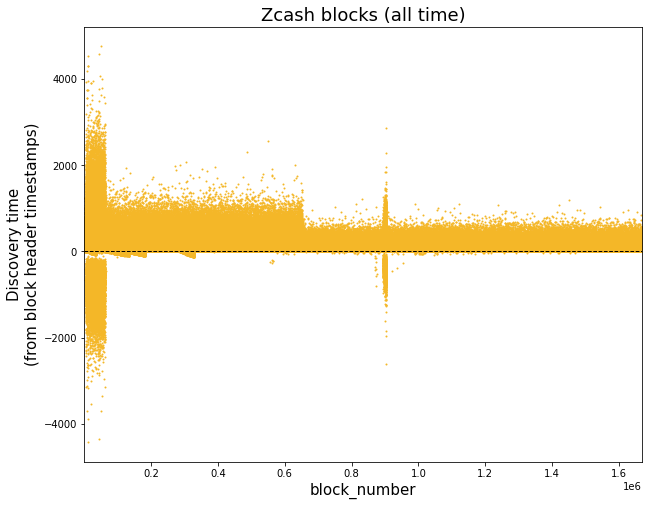

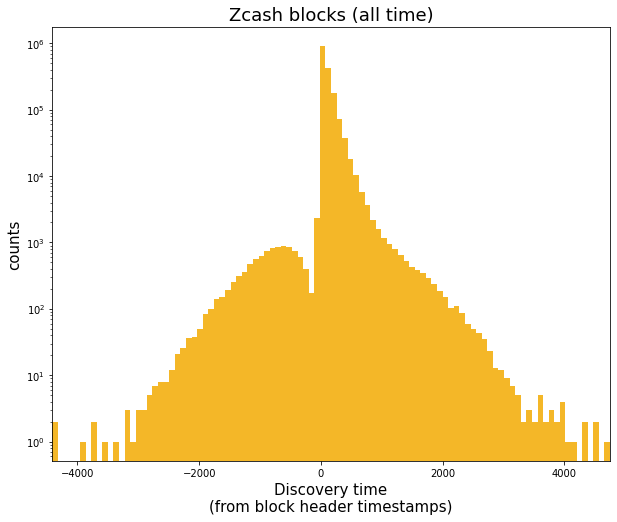

In [10]:
label: str = 'Discovery time\n(from block header timestamps)'
title: str = "Zcash blocks (all time)"
blockchain.scatter('discovery_time_sec', grid=False, markersize=1, title=title, ylabel=label)
plt.axhline(y=0, color='k', linestyle='--', linewidth=1)
blockchain.hist('discovery_time_sec', grid=False, log_axes='y', bins=100, title=title, xlabel=label);

Make a slice with just recent blocks (since Blossom activation, for example)

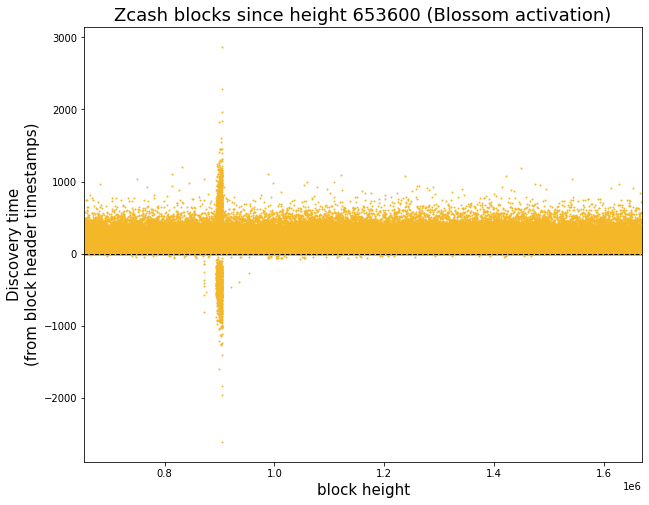

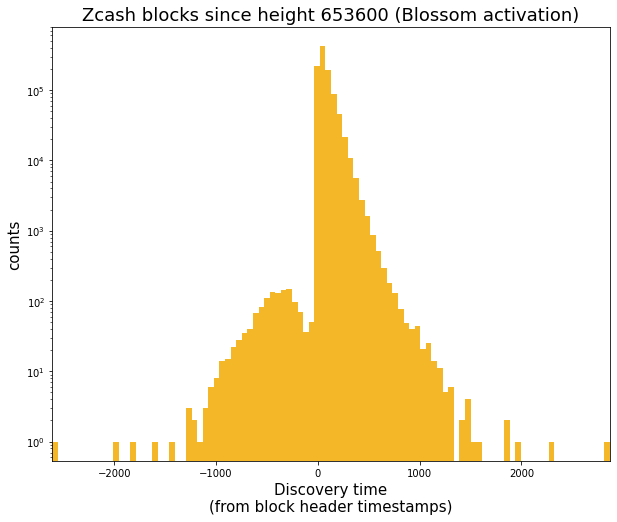

In [11]:
min_height: int = 653_600  # Blossom activation
blockchain_recent: Blockchain = deepcopy(blockchain)
blockchain_recent.data = blockchain_recent.data.iloc[min_height - 1:, :]
title: str = f"Zcash blocks since height {min_height} (Blossom activation)"
blockchain_recent.scatter('discovery_time_sec', grid=False, markersize=1, title=title, ylabel=label, xlabel='block height')
plt.axhline(y=0, color='k', linestyle='--', linewidth=1)
blockchain_recent.hist('discovery_time_sec', grid=False, log_axes='y', bins=100, title=title, xlabel=label);

### Examine more recent instances of Merlin blocks

Sorted by recency:

In [12]:
blockchain_recent.data[blockchain_recent.data['discovery_time_sec'] < 0].sort_values(by='block_number', ascending=False,
                                                                                     inplace=False).head()

,block_number,block_timestamp,block_timestamp_int,discovery_time_sec,block_number_diff
1467594,1467596,2021-11-21 05:01:32 UTC,1.637471e+09,-38.0,1.0
1454238,1454240,2021-11-09 13:06:51 UTC,1.636463e+09,-36.0,1.0
1421945,1421947,2021-10-12 08:42:14 UTC,1.634028e+09,-30.0,1.0
1419679,1419681,2021-10-10 09:01:00 UTC,1.633856e+09,-26.0,1.0
1418646,1418648,2021-10-09 11:19:58 UTC,1.633778e+09,-50.0,1.0


Look at the block before and after the most recent Merlin block

In [13]:
look_around_block: int = 1_467_596
blockchain_recent.data[blockchain_recent.data.block_number.between(look_around_block - 1, look_around_block + 1)]

,block_number,block_timestamp,block_timestamp_int,discovery_time_sec,block_number_diff
1467593,1467595,2021-11-21 05:02:10 UTC,1.637471e+09,227.0,1.0
1467594,1467596,2021-11-21 05:01:32 UTC,1.637471e+09,-38.0,1.0
1467595,1467597,2021-11-21 05:03:16 UTC,1.637471e+09,104.0,1.0
